# Change value of lambda

In [1]:
import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

In [2]:
# Import libraries
import os
import xlrd
import math
import zipfile
import numbers
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from pathlib import Path
import time
from ctgan.tablegan import TableganSynthesizer
from ctgan import CTGANSynthesizer
from ctgan import TVAESynthesizer
from sklearn.model_selection import train_test_split

In [3]:
num_epochs = 300

In [4]:
home = str(Path.home())

In [5]:
home

'C:\\Users\\stazt'

In [6]:
# Load cleaned 2016-2018 OVS datasets; replace NAs by -1
OVS1618 = pd.read_csv(home + '/Documents/nBox/Project Ultron/Milestone 3/Dataset/Cleaned (Outliers Removed)/Reduced to Benchmarks-1.csv')

In [7]:
OVS1618.head()

,Expenditure on Accommodation (c4.tot.new),Expenditure on Accommodation (c4.tot.new)_cat,Expenditure on F&B (c6.tot.new),Expenditure on F&B (c6.tot.new)_cat,"Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)","Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)_cat",Expenditure on Casual Dining (c6c_2.r),Expenditure on Casual Dining (c6c_2.r)_cat,Expenditure on Transport (c7.tot.new),Expenditure on Transport (c7.tot.new)_cat,...,Mode of Transport (m1),Main POV - Leisure/Holiday (b13a_112),Main POV - Visiting Friends/Family (b13a_114),Main POV - Business (b13a_116),Main POV - Healthcare (b113_117),Main POV - Education/Training/Workshop (b13a_118),Main POV - Others (b13a_119),Travel Package (c1a),"Accommodation - Hotels (c4a_1, c4a_2, c4a_3)","Accommodation - Others (c4a_4, c4a_5, c4a_7, c4a_8)"
0,679.04,0,400.0,0,-1.0,1,400.0,0,50.0,0,...,1,1,0,0,0,0,0,1,1,0
1,-1.00,1,130.0,0,100.0,0,30.0,0,100.0,0,...,1,1,1,0,0,0,0,2,0,0
2,-1.00,1,120.0,0,120.0,0,-1.0,1,40.0,0,...,1,0,0,0,0,0,0,2,0,0
3,-1.00,1,80.0,0,-1.0,1,80.0,0,100.0,0,...,1,1,1,0,0,0,0,2,0,0
4,130.00,0,60.0,0,60.0,0,-1.0,1,40.0,0,...,1,1,0,0,0,0,0,2,0,1


In [8]:
OVS1618.shape

(66030, 38)

In [9]:
# List of 14 expenditure variables
list_expnd = ['Expenditure on Accommodation (c4.tot.new)',
              'Expenditure on F&B (c6.tot.new)',
              'Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)',
              'Expenditure on Casual Dining (c6c_2.r)',
              'Expenditure on Transport (c7.tot.new)', 
              'Expenditure on Sightseeing & Entertainment (c10.tot.new)',
              'Expenditure on Sightseeing (c10c_1.r)',
              'Expenditure on Attractions (c10c_2.r)',
              'Expenditure on Shopping (t7.m.any)',          
              'Expenditure on Healthcare & Wellness Products (t7.m.well)',
              'Expenditure on Confectionery & Food Items (t7.m.food)',
              'Expenditure on Fashion (t7.m.fash)',
              'Expenditure on Other Shopping Items (t7.m.gift + t7.m.oth)',
              'Package Expenditure Per Person (c1b.r)']

# List of 10 categorical variables
list_cat = ['Mode of Transport (m1)',
            'Main POV - Leisure/Holiday (b13a_112)',
            'Main POV - Visiting Friends/Family (b13a_114)',
            'Main POV - Business (b13a_116)',
            'Main POV - Healthcare (b113_117)',
            'Main POV - Education/Training/Workshop (b13a_118)',
            'Main POV - Others (b13a_119)',
            'Travel Package (c1a)',
            'Accommodation - Hotels (c4a_1, c4a_2, c4a_3)',
            'Accommodation - Others (c4a_4, c4a_5, c4a_7, c4a_8)']

In [10]:
with open(home + '/Documents/nBox/Project Ultron/Milestone 3/Dataset/Cleaned (Outliers Removed)/binary_categorical_columns.txt',"r+")   as f:
    new_cat_list = f.read().splitlines() 

In [11]:
new_cat_list

['Expenditure on Accommodation (c4.tot.new)_cat',
 'Expenditure on F&B (c6.tot.new)_cat',
 'Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)_cat',
 'Expenditure on Casual Dining (c6c_2.r)_cat',
 'Expenditure on Transport (c7.tot.new)_cat',
 'Expenditure on Sightseeing & Entertainment (c10.tot.new)_cat',
 'Expenditure on Sightseeing (c10c_1.r)_cat',
 'Expenditure on Attractions (c10c_2.r)_cat',
 'Expenditure on Shopping (t7.m.any)_cat',
 'Expenditure on Healthcare & Wellness Products (t7.m.well)_cat',
 'Expenditure on Confectionery & Food Items (t7.m.food)_cat',
 'Expenditure on Fashion (t7.m.fash)_cat',
 'Expenditure on Other Shopping Items (t7.m.gift + t7.m.oth)_cat',
 'Package Expenditure Per Person (c1b.r)_cat']

In [12]:
cat_cols = new_cat_list + list_cat

In [13]:
len(cat_cols)

24

In [14]:
## split data into training/validation/test
OVS1618_train_val, OVS1618_test = train_test_split(OVS1618, test_size=0.15, random_state=42)

In [15]:
OVS1618_train_val.shape

(56125, 38)

In [16]:
OVS1618_test.shape

(9905, 38)

# First Five categorical columns

# lambda = 5

In [17]:
ctgan = CTGANSynthesizer()
print('Training CTGAN is starting')
start_time = time.time()
ctgan.fit(OVS1618_train_val[cat_cols[0:5]], discrete_columns=cat_cols[0:5], epochs=100, model_summary=False, trans="VGM",use_cond_gen=True)
elapsed_time = time.time() - start_time

Training CTGAN is starting
Learning rate:  0.0002
Batch size:  500
Number of Epochs:  300
training data shape:  (46247, 5)
validation data shape:  (9878, 5)
transformed data shape:  (46247, 10)
data dimension: 10
Dropout rate:  0.5
Epoch 1, Loss G: 0.4710, Loss D: -0.1691
Epoch 2, Loss G: 0.3374, Loss D: -0.0357
Epoch 3, Loss G: 0.3442, Loss D: -0.0922
Epoch 4, Loss G: -0.0180, Loss D: -0.1295
Epoch 5, Loss G: -0.0964, Loss D: -0.1401
Epoch 6, Loss G: -0.3670, Loss D: -0.0735
Epoch 7, Loss G: -0.3391, Loss D: 0.1411
Epoch 8, Loss G: -0.2399, Loss D: -0.3148
Epoch 9, Loss G: -0.2464, Loss D: -0.0440
Epoch 10, Loss G: -0.5120, Loss D: 0.1200
Epoch 11, Loss G: -0.4850, Loss D: -0.1385
Epoch 12, Loss G: -0.9992, Loss D: -0.1785
Epoch 13, Loss G: -0.7807, Loss D: -0.0533
Epoch 14, Loss G: -0.8018, Loss D: -0.1297
Epoch 15, Loss G: -0.8823, Loss D: -0.2903
Epoch 16, Loss G: -0.9411, Loss D: 0.2497
Epoch 17, Loss G: -0.8771, Loss D: 0.0276
Epoch 18, Loss G: -0.9714, Loss D: -0.0280
Epoch 19, 

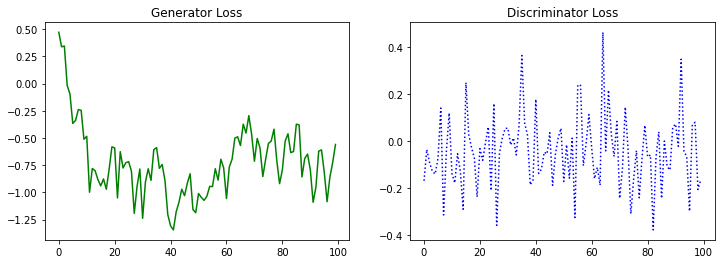

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].plot(ctgan.generator_loss,'-g')
ax[0].set_title('Generator Loss')

ax[1].plot(ctgan.discriminator_loss,':b')
ax[1].set_title('Discriminator Loss');

# lambda = 15

In [17]:
ctgan = CTGANSynthesizer()
print('Training CTGAN is starting')
start_time = time.time()
ctgan.fit(OVS1618_train_val[cat_cols[0:5]], discrete_columns=cat_cols[0:5], epochs=100, model_summary=False, trans="VGM",use_cond_gen=True)
elapsed_time = time.time() - start_time

Training CTGAN is starting
Learning rate:  0.0002
Batch size:  500
Number of Epochs:  300
training data shape:  (46247, 5)
validation data shape:  (9878, 5)
transformed data shape:  (46247, 10)
data dimension: 10
Dropout rate:  0.5
Epoch 1, Loss G: 0.4514, Loss D: -0.1675
Epoch 2, Loss G: 0.3472, Loss D: -0.0332
Epoch 3, Loss G: 0.3487, Loss D: -0.0499
Epoch 4, Loss G: 0.0503, Loss D: -0.1169
Epoch 5, Loss G: 0.0565, Loss D: -0.1289
Epoch 6, Loss G: -0.2903, Loss D: -0.0815
Epoch 7, Loss G: -0.3146, Loss D: 0.1574
Epoch 8, Loss G: -0.2159, Loss D: -0.3216
Epoch 9, Loss G: -0.3259, Loss D: -0.0692
Epoch 10, Loss G: -0.5707, Loss D: 0.1165
Epoch 11, Loss G: -0.6057, Loss D: -0.1675
Epoch 12, Loss G: -0.9415, Loss D: -0.1488
Epoch 13, Loss G: -0.6700, Loss D: 0.0171
Epoch 14, Loss G: -0.6787, Loss D: -0.1585
Epoch 15, Loss G: -0.6782, Loss D: -0.2111
Epoch 16, Loss G: -0.5901, Loss D: 0.2521
Epoch 17, Loss G: -0.5172, Loss D: 0.2238
Epoch 18, Loss G: -0.7931, Loss D: -0.0536
Epoch 19, Los

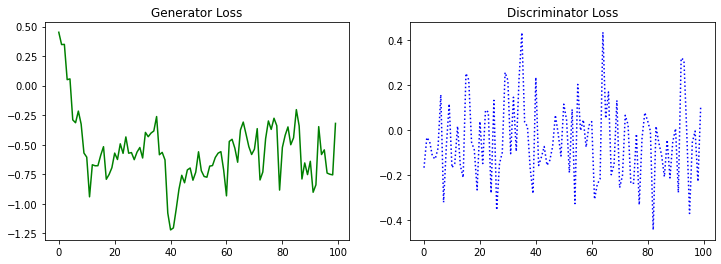

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].plot(ctgan.generator_loss,'-g')
ax[0].set_title('Generator Loss')

ax[1].plot(ctgan.discriminator_loss,':b')
ax[1].set_title('Discriminator Loss');